### Import Libraries

In [3]:
import os 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from PIL import Image
from sklearn.model_selection import train_test_split


In [4]:
while os.path.basename(os.getcwd()) != "ML_BarePass":
    os.chdir((os.path.dirname(os.getcwd())))


In [5]:
os.getcwd()

'/Users/minhdang/Library/CloudStorage/OneDrive-Personal/242/ML/ML_BarePass'

### Create dataframe

In [6]:
import os
import pandas as pd

raw_data_dir = os.path.join(os.getcwd(), 'data', 'raw', 'archive', 'Multi Cancer', 'Multi Cancer')
target_folder = 'Brain Cancer'

all_path = os.path.join(raw_data_dir, target_folder)

# Collect file paths and labels using os.walk()
paths, labels = [], []

if os.path.isdir(all_path):
    for root, _, files in os.walk(all_path):
        label = os.path.basename(root)  # The last folder name is the label
        if root != all_path:  # Ensure we don't include the root folder itself
            paths.extend(os.path.join(root, file) for file in files)
            labels.extend([label] * len(files))



# Create DataFrame
df = pd.DataFrame({'filepath': paths, 'labels': labels})

In [7]:
df.sample(10)

,filepath,labels
4955,/Users/minhdang/Library/CloudStorage/OneDrive-...,brain_menin
1005,/Users/minhdang/Library/CloudStorage/OneDrive-...,brain_menin
1827,/Users/minhdang/Library/CloudStorage/OneDrive-...,brain_menin
978,/Users/minhdang/Library/CloudStorage/OneDrive-...,brain_menin
4918,/Users/minhdang/Library/CloudStorage/OneDrive-...,brain_menin
7338,/Users/minhdang/Library/CloudStorage/OneDrive-...,brain_tumor
13895,/Users/minhdang/Library/CloudStorage/OneDrive-...,brain_glioma
3074,/Users/minhdang/Library/CloudStorage/OneDrive-...,brain_menin
2694,/Users/minhdang/Library/CloudStorage/OneDrive-...,brain_menin
5270,/Users/minhdang/Library/CloudStorage/OneDrive-...,brain_tumor


### Statistics

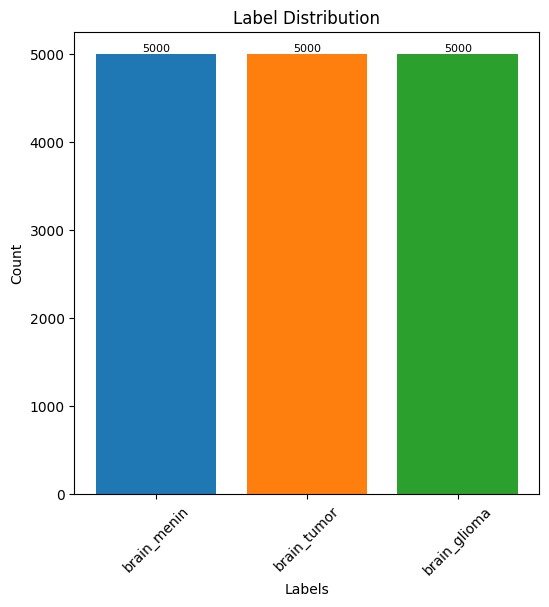

In [8]:
count=df['labels'].value_counts().reset_index()
count.columns=['labels','count']

# Generating unique colors for each bar
colors = plt.colormaps.get_cmap('tab10')

# Creating a vertical bar plot with different colors
plt.figure(figsize=(6, 6))
bars = plt.bar(count['labels'], count['count'], color=[colors(i) for i in range(len(count))])

# Adding numbers on top of bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(bar.get_height()), 
             ha='center', va='bottom', fontsize=8)

# Labels and title
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title("Label Distribution")
plt.xticks(rotation=45)

# Show the plot
plt.show()


The dataset is balanced 

In [9]:
# # Function to compute max, min, and range pixel values for an image
# def get_image_stats(filepath):
#         image = Image.open(filepath).convert("L")  # Convert to grayscale for simplicity
#         img_array = np.array(image)
#         max_pixel = np.max(img_array)
#         min_pixel = np.min(img_array)
#         pixel_range = max_pixel - min_pixel
#         return max_pixel, min_pixel, pixel_range
    

# # Applying the function to each image in the dataframe
# df_stats = df['filepath'].apply(lambda x: pd.Series(get_image_stats(x), index=['max_pixel', 'min_pixel', 'pixel_range']))

# # Merging results into a new dataframe
# df_result = pd.concat([df, df_stats], axis=1)


In [10]:
# df_result

In [11]:
# is_valid = (df_result['max_pixel'] <= 255).all() and (df_result['min_pixel'] >= 0).all()
# is_valid

### Plot some images

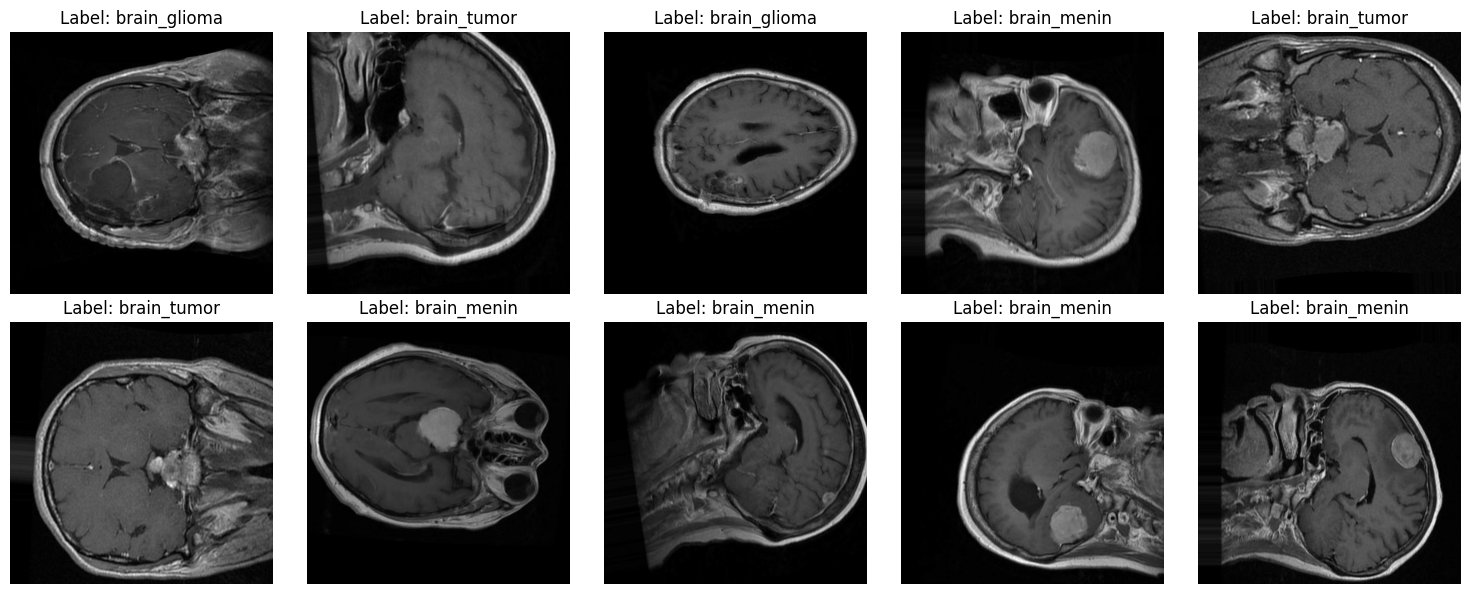

In [12]:
# Sampling 10 images
samples = df.sample(10, random_state=42)

# Creating a figure for displaying images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Flatten axes for easy iteration
axes = axes.flatten()

# Displaying images with labels
for i, (idx, row) in enumerate(samples.iterrows()):
    try:
        img = Image.open(row['filepath'])
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {row['labels']}")
        axes[i].axis('off')
    except Exception as e:
        axes[i].set_title("Error loading image")
        axes[i].axis('off')

# Adjust layout and show plot
plt.tight_layout()
plt.show()


### Preprocessing: Cropping + Resizing

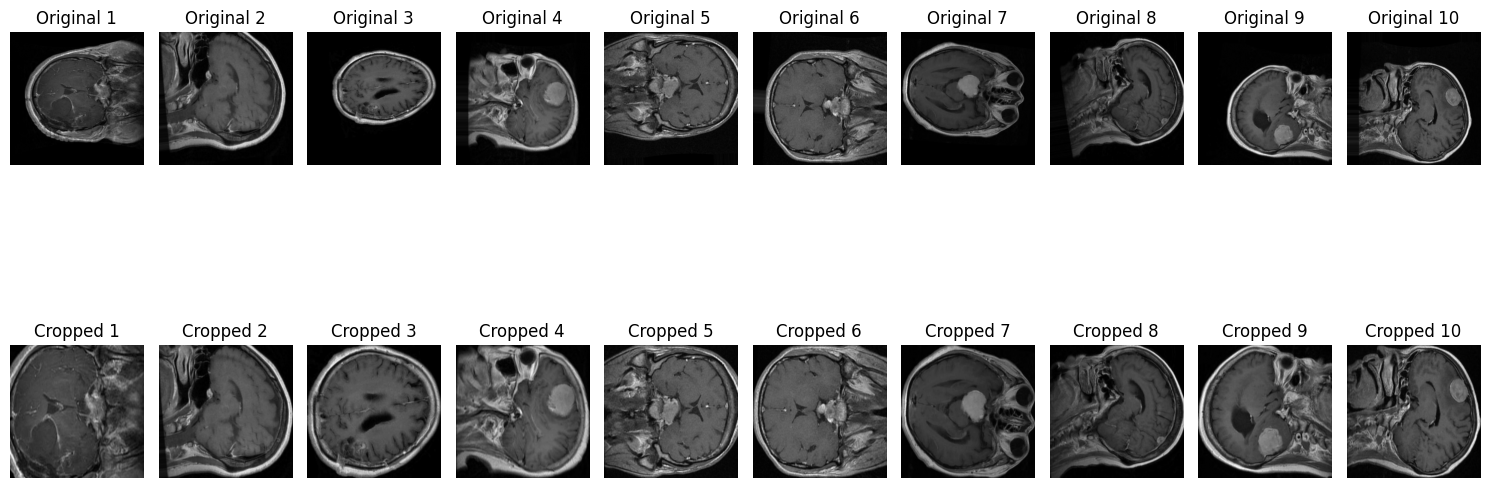

In [41]:
# Set up the plot with 10 subplots (2 rows and 10 columns)
from skimage import io, transform, color
from keras.api.preprocessing.image import img_to_array
from src.data.preprocess import crop_brain_contour
plt.figure(figsize=(15, 8))

# Loop through each sample image
for i, image_path in enumerate(samples.filepath.values):
    # Load the original image
    original_image = io.imread(image_path)
    original_image = color.rgb2gray(original_image)
    original_image = (original_image * 255).astype(np.uint8)
    
    # Apply the crop_brain_contour function to get the cropped image
    cropped_image = crop_brain_contour(original_image)

    image_resized = transform.resize(cropped_image, (224, 224), mode='reflect', anti_aliasing=True)
    image_array = img_to_array(image_resized)

    # Plot the original image (in the left column)
    plt.subplot(2, 10, i + 1)
    plt.imshow(original_image,cmap='gray')
    plt.title(f"Original {i+1}")
    plt.axis('off')

    # Plot the cropped image (in the right column)
    plt.subplot(2, 10, i + 11)
    plt.imshow(image_array,cmap='gray')
    plt.title(f"Cropped {i+1}")
    plt.axis('off')

# Show the plot
plt.tight_layout()
plt.show()

### Load dataset

In [13]:
from src.data.make_dataset import load_data

In [17]:
dataset = load_data(df)

469/469 ━━━━━━━━━━━━━━━━━━━━ 106s 225ms/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 1000s 2s/step


### Splitting dataset

In [26]:
X = dataset['fused_feature']
y = dataset['labels']

In [27]:
X.shape

(15000, 1792)

In [28]:
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check the sizes of the splits
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# Print the value counts in y_train and y_test using numpy
print("\nClass distribution in y_train:")
unique_train, counts_train = np.unique(y_train, return_counts=True)
for class_label, count in zip(unique_train, counts_train):
    print(f"Class {class_label}: {count} samples")

print("\nClass distribution in y_test:")
unique_test, counts_test = np.unique(y_test, return_counts=True)
for class_label, count in zip(unique_test, counts_test):
    print(f"Class {class_label}: {count} samples")


Training set size: 12000 samples
Test set size: 3000 samples

Class distribution in y_train:
Class 0: 4000 samples
Class 1: 4000 samples
Class 2: 4000 samples

Class distribution in y_test:
Class 0: 1000 samples
Class 1: 1000 samples
Class 2: 1000 samples


In [29]:
save_dir = os.path.join(os.getcwd(),'data','processed')

train_folder = os.path.join(save_dir,'train')
# val_folder = os.path.join(save_dir,'val')
test_folder = os.path.join(save_dir,'test')

os.makedirs(train_folder,exist_ok=True)
# os.makedirs(val_folder,exist_ok=True)
os.makedirs(test_folder,exist_ok=True)


X_train_file = os.path.join(train_folder,'X_train.npy')
y_train_file = os.path.join(train_folder,'y_train.npy')

# X_val_file = os.path.join(val_folder,'X_val.npy')
# y_val_file = os.path.join(val_folder,'y_val.npy')

X_test_file = os.path.join(test_folder,'X_test.npy')
y_test_file = os.path.join(test_folder,'y_test.npy')

# Save training and test sets
np.save(X_train_file, X_train)
np.save(y_train_file, y_train)

# np.save(X_val_file, X_val)
# np.save(y_val_file, y_val)

np.save(X_test_file, X_test)
np.save(y_test_file, y_test)

In [30]:
import numpy as np

save_dir = os.path.join(os.getcwd(),'data','processed')

train_folder = os.path.join(save_dir,'train')
# val_folder = os.path.join(save_dir,'val')
test_folder = os.path.join(save_dir,'test')

X_train_file = os.path.join(train_folder,'X_train.npy')
y_train_file = os.path.join(train_folder,'y_train.npy')

X_test_file = os.path.join(test_folder,'X_test.npy')
y_test_file = os.path.join(test_folder,'y_test.npy')

# To load the data later
X_train = np.load(X_train_file)
y_train = np.load(y_train_file)

X_test = np.load(X_test_file)
y_test = np.load(y_test_file)

### Models

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import itertools
from sklearn.decomposition import PCA

In [32]:
# Define methods for classifying samples
classifiers = {
    "SVC": SVC(),
}

reducers = {
    'PCA': PCA()
}

# Define parameters for each method
parameters = {
    "PCA__n_components": [0.1,0.2,0.5,0.8, None],
    "DecisionTreeClassifier__criterion": ['entropy','gini'],
    "SVC__kernel": ['poly'],
    "SVC__degree": [3]
}


In [33]:
def generate_pipes_dict(pipe_dict):
    result = {}
    for config, steps in pipe_dict.items():
        
        #result[config] = generate_pipes(steps)
        result[config]= generate_pipes(steps)
    return result

def generate_pipes(pipe_config):
  
  pipe_config = [list(step.items()) for _, step in pipe_config]
  pipe_config = list(itertools.product(*pipe_config))
  pipe_names = list(map(lambda steps: [name for name,_ in steps], pipe_config))
  pipe_names = list(map(lambda L: ">".join(L), pipe_names))
  pipes = [Pipeline(cfg) for cfg in pipe_config]
  temp = zip(pipe_names, pipes)
  return dict(temp)

def find_hyperparams(pipe_mapper_dict):
  print("Start the tunning process ...")
  best_pipes = {}
  results = []
  counter = 0
  for name, pipe_mapper in pipe_mapper_dict.items():
   
    for idx, pipe_name in enumerate(list(pipe_mapper.keys())):
        
        print(f"{counter + 1}. Tuning pipe: {pipe_name}")

        # Select parameters related to the current pipeline:
        param_grid = {}
        for step_name in pipe_name.split('>'):
            for param_name in parameters.keys():
                if param_name.split("__")[0] == (step_name):
                    param_grid[param_name] = parameters[param_name]

        # Create a finder and search for the best parameters
        pipe = pipe_mapper[pipe_name]
        finder = GridSearchCV(pipe, param_grid=param_grid, cv=5,
                            scoring= "accuracy",
                            refit= True)

        finder.fit(X_train, y_train)
        print("\t best-params: {:>15s}".format(str(finder.best_params_)))
        print(f"\t best-score (PR_Auc): {finder.best_score_:15.2f}")
        #print(f"\t cv_result_: {finder.cv_results_}")
        print()

        # Store best pipe
        best_pipes[pipe_name] = finder.best_estimator_

        # Add results to a dataframe
        rs_item = {"Method": pipe_name, "Accuracy": finder.best_score_}
        for key, value in finder.best_params_.items():
            rs_item[key] = value
        results.append(rs_item)

        counter +=1

  print("The tunning is done!")
  tuned_table = pd.DataFrame(results)
  tuned_table.set_index('Method')
  return tuned_table, best_pipes


In [34]:
pipe_dict = {
    "Normal": [
        ('classifier', classifiers)
    ]
    ,
    "Reduced": [
        ('reducers', reducers),
        ('classifier', classifiers)
    ]

}

pipe_mapper_dict = generate_pipes_dict(pipe_dict)

In [35]:
pipe_mapper_dict

{'Normal': {'SVC': Pipeline(steps=(('SVC', SVC()),))},
 'Reduced': {'PCA>SVC': Pipeline(steps=(('PCA', PCA()), ('SVC', SVC())))}}

In [36]:
tuned_table, best_pipes = find_hyperparams(pipe_mapper_dict)

Start the tunning process ...
1. Tuning pipe: SVC
	 best-params: {'SVC__degree': 3, 'SVC__kernel': 'poly'}
	 best-score (PR_Auc):            0.48

2. Tuning pipe: PCA>SVC
	 best-params: {'PCA__n_components': None, 'SVC__degree': 3, 'SVC__kernel': 'poly'}
	 best-score (PR_Auc):            0.68

The tunning is done!


In [47]:
from src.data.preprocess import crop_brain_contour
import cv2
samples = df.sample(10).filepath.values